# Exercises

First, I added the code necessary to start doing the exercise (exercise 2):

In [1]:
import numpy as np
import scipy
import scipy.stats
import scipy.io
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets
from tqdm import tqdm
import seaborn as sns
import pickle
import sys
import os
import math
sys.path.append(os.path.abspath("code"))
from utils import download_data

sns.set_theme(context='notebook',style='white',font_scale=1.5,
              rc = {'axes.spines.top':False,'axes.spines.right':False})

In [2]:
# Download lesson data
download_data('https://surfdrive.surf.nl/files/index.php/s/FeDX3LfbJ4pC7T6')

In [3]:
#import data
with open('data/psth_data.pickle', 'rb') as handle:
    data = pickle.load(handle)

spike_times = data['spike_times']
stim_onsets = data['stim_onsets']
stim_type = data['stim_type']
stim_duration = data['stim_duration']

In [4]:
# cut and align to stimulus presentation
psth_onset = -0.5
psth_offset = stim_duration+0.5

aligned_spikes_stim1 = []
stim1_onsets = stim_onsets[stim_type==1]

for cell_spikes in spike_times:
    aligned_spikes = []
    for stim_onset in stim1_onsets:
        onset = stim_onset + psth_onset
        offset = stim_onset +psth_offset
        # take only spikes during stimulus, aligned to stimulus onset
        stim_spikes = [spike-stim_onset for spike in cell_spikes if (spike>=onset and spike<offset)]
        aligned_spikes.append(stim_spikes)

    aligned_spikes_stim1.append(aligned_spikes)

aligned_spikes_stim2 = []
stim1_onsets = stim_onsets[stim_type==2]

for cell_spikes in spike_times:
    aligned_spikes = []
    for stim_onset in stim1_onsets:
        onset = stim_onset + psth_onset
        offset = stim_onset +psth_offset
        # take only spikes during stimulus, aligned to stimulus onset
        stim_spikes = [spike-stim_onset for spike in cell_spikes if (spike>=onset and spike<offset)]
        aligned_spikes.append(stim_spikes)

    aligned_spikes_stim2.append(aligned_spikes)
    

In [5]:
# cut and align to stimulus presentation
psth_onset = -0.5
psth_offset = stim_duration+0.5


aligned_spikes_stim1 = []
stim1_onsets = stim_onsets[stim_type==1]

In [6]:
track_length = 200. # the length of our linear track (eg in centimeter)
average_firing_rate = 5 # the peak firing rate, averaged across the population 
n_cells = 100 # how many cells we are recording
pf_centers = np.random.rand(n_cells) * track_length # the centers of the place fields for all cells drawn randomly with a uniform distribution on the track
pf_size = np.random.gamma(10, size=n_cells) # the size (width) of the place fields, drawn randomly from a gamma distribution 
pf_rate = np.random.exponential(scale=average_firing_rate, size=n_cells) # the peak firing rate for each cell, drawn from an exponential distribution

In [7]:
bins = np.arange(0., 200.)
true_firing_rate_maps = np.zeros((n_cells, len(bins)))
for i in range(n_cells):
    true_firing_rate_maps[i,:] = pf_rate[i] * np.exp(-((bins-pf_centers[i])**2)/(2*pf_size[i]**2))

n_runs = 20 
av_running_speed = 10 # the average running speed (in cm/s)
fps = 30 # the number of "video frames" per second 
running_speed_a = np.random.chisquare(10, size=n_runs) # running speed in the two directions
running_speed_b = np.random.chisquare(10, size=n_runs) 

stopping_time_a = np.random.chisquare(15, size=n_runs) # the time the mouse will spend at the two ends of the track
stopping_time_b = np.random.chisquare(15, size=n_runs)

x = np.array([])
for i in range(n_runs):
    stop1 = np.ones((int(stopping_time_a[i]*fps),)) * 0.
    run_length = len(bins) * fps / running_speed_a[i]
    run1 = np.linspace(0., float(len(bins)-1), int(run_length))
    stop2 = np.ones((int(stopping_time_b[i]*fps),)) * (len(bins)-1.)
    run_length = len(bins) * fps / running_speed_b[i]
    run2 = np.linspace(len(bins)-1., 0., int(run_length))
    x = np.concatenate((x, stop1, run1, stop2, run2))
t = np.arange(len(x))/fps
sampling_rate = 10000.
t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
x_sampling = np.floor(np.interp(t_sampling, t, x))
noise_firing_rate = 0.1 # the baseline noise firing rate
spikes = []

for i in tqdm(range(n_cells)):
    inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
    spikes_loc = np.random.poisson(inst_rate/sampling_rate)
    sp = np.argwhere(spikes_loc)
    t_sp = t_sampling[sp]
    spikes.append(t_sp)
spike_positions = [np.interp(s, t, x) for s in spikes]
space_bins = np.arange(0., 200., 5.)

# we compute histograms for eaxh cell
spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]

# put them together into a matrix of floating point numbers (for plotting)
spikes_hist = np.vstack(spikes_hist).astype(np.float64)

# we also need an "occupancy histogram" in order to normalize the firing rates maps 
occupancy = np.histogram(x, space_bins)[0] /  fps

firing_rate_maps = spikes_hist / occupancy 

100%|█████████████████████████████████████████| 100/100 [01:24<00:00,  1.18it/s]


## Exercise 2 - mutual information
---
A - Implement the mutual information formula discussed in the lesson, and apply it to the place cell data we simulated.

B - Adapt the simulation so that you can systematically vary 1) Peak firing rate, 2) place cell size 3) baseline noise. 
Study how mutual information vary with these parameters. Use both definition of mutual information above, and discuss the differences between them. Make some plots to show how the dependency goes.

## A.

In [15]:
epsilon = 10**(-15)
lamb = np.mean(firing_rate_maps, axis=1) # average firing rate
lamb_x = firing_rate_maps #firing rate
p_occ = occupancy/np.sum(occupancy)#occupancy probability

In [19]:
I = np.zeros(100)
for i in range(len(lamb_x[1])):
    I[:] += lamb_x[:,i]*p_occ[i]*np.log2((lamb_x[:,i]+epsilon)/(lamb[:]))
    
I = I/lamb

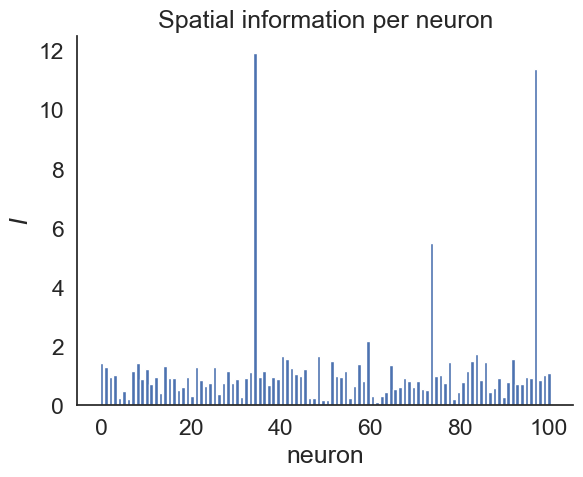

In [21]:
plt.bar(np.linspace(0,100,100), I)
plt.xlabel('neuron')
plt.ylabel(r'$I$')
plt.title('Spatial information per neuron')
plt.show()

## B.

#### Varying peak firing rates

In [22]:
#set variables
average_firing_rates = [1, 3, 5, 7, 10, 15, 20, 50]
track_length = 200. # the length of our linear track (eg in centimeter)
#average_firing_rate = 5 # the peak firing rate, averaged across the population 
n_cells = 100 # how many cells we are recording
bins = np.arange(0., 200.)
n_runs = 20 
av_running_speed = 10 # the average running speed (in cm/s)
fps = 30 # the number of "video frames" per second 
sampling_rate = 10000.
noise_firing_rate = 0.1 # the baseline noise firing rate
space_bins = np.arange(0., 200., 5.)
epsilon = 10**(-15)

running_speed_a = np.random.chisquare(10, size=n_runs) # running speed in the two directions
running_speed_b = np.random.chisquare(10, size=n_runs) 
stopping_time_a = np.random.chisquare(15, size=n_runs) # the time the mouse will spend at the two ends of the track
stopping_time_b = np.random.chisquare(15, size=n_runs)
x = np.array([])
for i in range(n_runs):
    stop1 = np.ones((int(stopping_time_a[i]*fps),)) * 0.
    run_length = len(bins) * fps / running_speed_a[i]
    run1 = np.linspace(0., float(len(bins)-1), int(run_length))
    stop2 = np.ones((int(stopping_time_b[i]*fps),)) * (len(bins)-1.)
    run_length = len(bins) * fps / running_speed_b[i]
    run2 = np.linspace(len(bins)-1., 0., int(run_length))
    x = np.concatenate((x, stop1, run1, stop2, run2))
t = np.arange(len(x))/fps
I = np.zeros([100, len(average_firing_rates)])
I_s = np.zeros([100, len(average_firing_rates)])

In [23]:
# calculate mutual information
pf_centers = np.random.rand(n_cells) * track_length # the centers of the place fields for all cells drawn randomly with a uniform distribution on the track
pf_size = np.random.gamma(10, size=n_cells) # the size (width) of the place fields, drawn randomly from a gamma distribution 

for k in range(len(average_firing_rates)):
    average_firing_rate = average_firing_rates[k]
    pf_rate = np.random.exponential(scale=average_firing_rate, size=n_cells) # the peak firing rate for each cell, drawn from an exponential distribution
    true_firing_rate_maps = np.zeros((n_cells, len(bins)))
    for i in range(n_cells):
        true_firing_rate_maps[i,:] = pf_rate[i] * np.exp(-((bins-pf_centers[i])**2)/(2*pf_size[i]**2))
    t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
    x_sampling = np.floor(np.interp(t_sampling, t, x))
    spikes = []
    for i in tqdm(range(n_cells)):
        inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
        spikes_loc = np.random.poisson(inst_rate/sampling_rate)
        sp = np.argwhere(spikes_loc)
        t_sp = t_sampling[sp]
        spikes.append(t_sp)
    spike_positions = [np.interp(s, t, x) for s in spikes]
    spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]
    spikes_hist = np.vstack(spikes_hist).astype(np.float64)
    occupancy = np.histogram(x, space_bins)[0] /  fps
    firing_rate_maps = spikes_hist / occupancy 
    lamb = np.mean(firing_rate_maps, axis=1) # average firing rate
    lamb_x = firing_rate_maps #firing rate
    p_occ = occupancy/np.sum(occupancy)#occupancy probability
    for i in range(len(lamb_x[1])):
        I[:,k] += lamb_x[:,i]*p_occ[i]*np.log2((lamb_x[:,i]+epsilon)/(lamb[:]))
    I_s[:,k] = I[:,k]/lamb

100%|█████████████████████████████████████████| 100/100 [00:49<00:00,  2.02it/s]


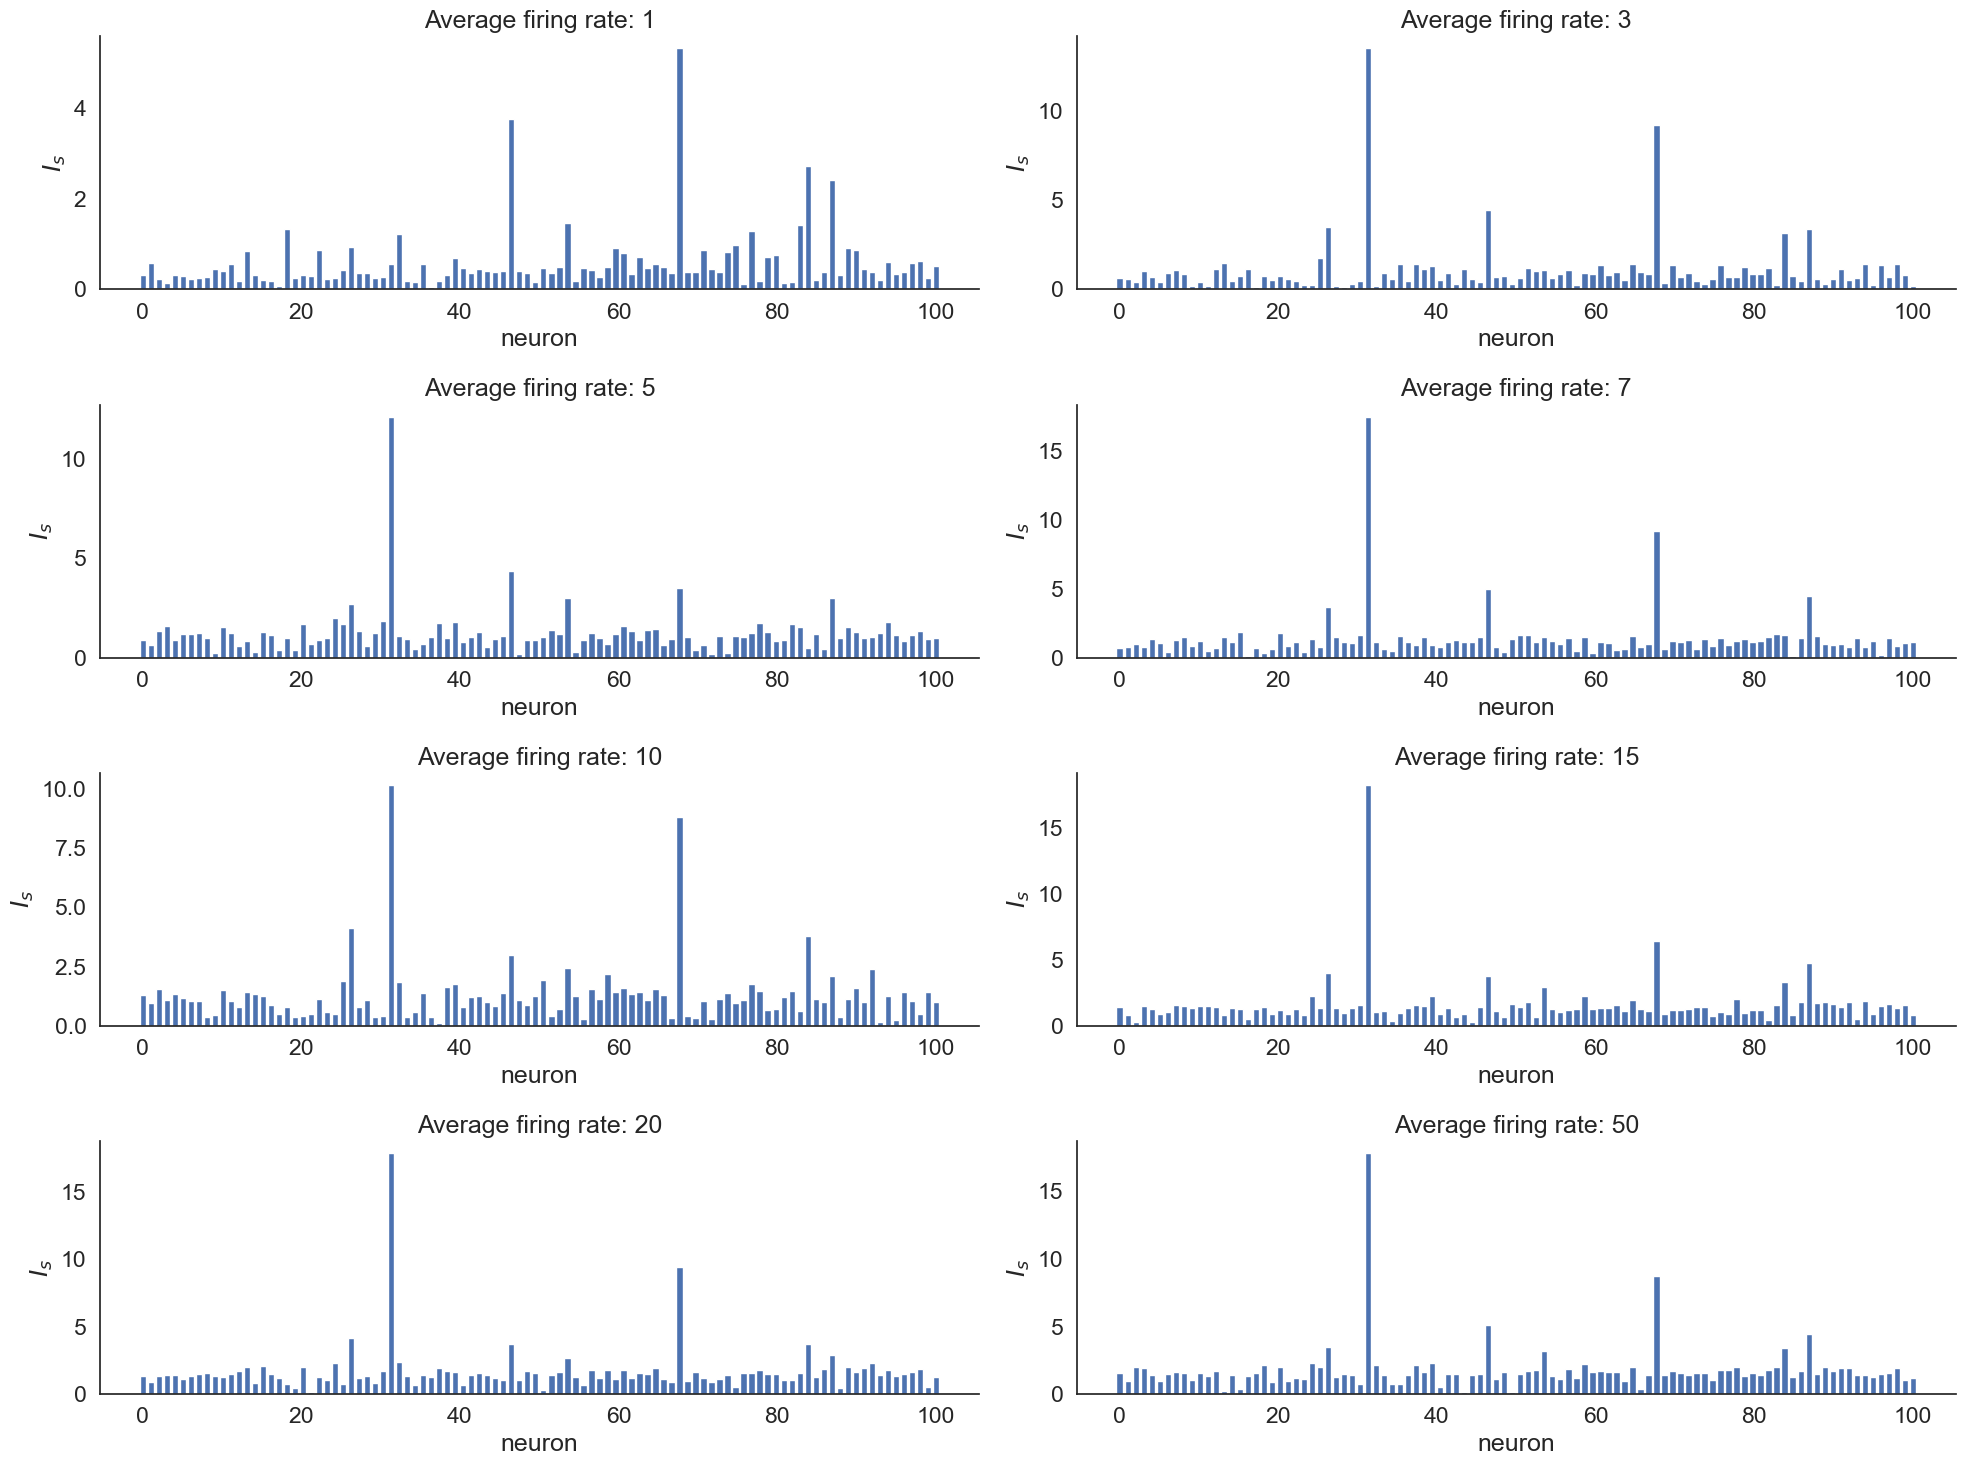

In [26]:
plt.figure(figsize=(20, 15))

for k in range(len(average_firing_rates)):
    plt.subplot(4,2,k+1)
    plt.bar(np.linspace(0,100,100), I_s[:,k])
    plt.xlabel('neuron')
    plt.ylabel(r'$I_s$')
    plt.title('Average firing rate: {}'.format(average_firing_rates[k]))

plt.tight_layout()
plt.show()

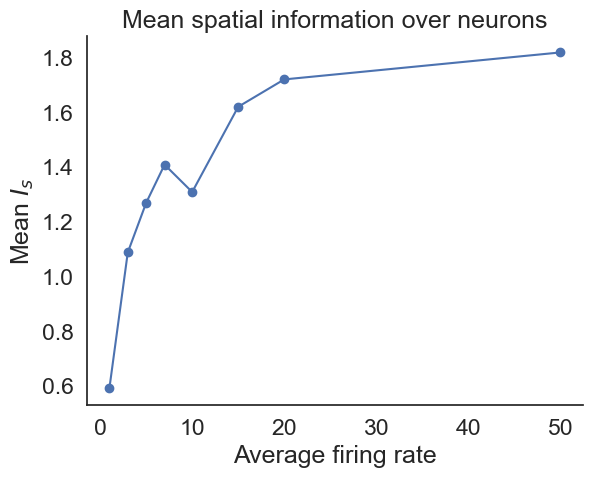

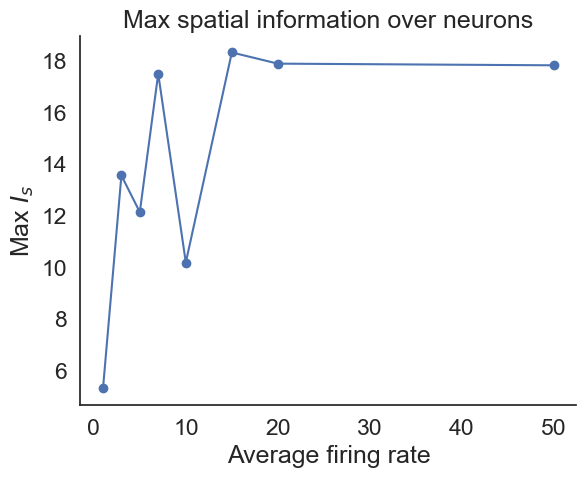

In [25]:
Is_mean = np.zeros(len(average_firing_rates))
Is_max = np.zeros(len(average_firing_rates))
for k in range(len(average_firing_rates)):
    Is_mean[k] = np.mean(I_s[:,k])
    Is_max[k] = np.max(I_s[:,k]) #define max I_s for easier analysis

plt.plot(average_firing_rates, Is_mean, marker='o')
plt.xlabel('Average firing rate')
plt.ylabel(r'Mean $I_s$')

plt.title('Mean spatial information over neurons')
plt.show()

plt.plot(average_firing_rates, Is_max, marker='o')
plt.xlabel('Average firing rate')
plt.ylabel(r'Max $I_s$')
plt.title('Max spatial information over neurons')
plt.show()

It appears that increasing the average firing rates of the neurons increases the mutual information. This is expected, since a higher average firing rate probably leads to a higher signal to noise ratio, hence increasing the amount of information.

#### Now, varying place cell size:

In [27]:
# set variables
gamma_values = [1, 3, 5, 7, 10, 15, 20, 50]
track_length = 200. # the length of our linear track (eg in centimeter)
average_firing_rate = 5 # the peak firing rate, averaged across the population 
n_cells = 100 # how many cells we are recording
bins = np.arange(0., 200.)
n_runs = 20 
av_running_speed = 10 # the average running speed (in cm/s)
fps = 30 # the number of "video frames" per second 
sampling_rate = 10000.
noise_firing_rate = 0.1 # the baseline noise firing rate
space_bins = np.arange(0., 200., 5.)
epsilon = 10**(-15)
I = np.zeros([100, len(average_firing_rates)])
I_s = np.zeros([100, len(average_firing_rates)])

running_speed_a = np.random.chisquare(10, size=n_runs) # running speed in the two directions
running_speed_b = np.random.chisquare(10, size=n_runs) 
stopping_time_a = np.random.chisquare(15, size=n_runs) # the time the mouse will spend at the two ends of the track
stopping_time_b = np.random.chisquare(15, size=n_runs)
x = np.array([])
for i in range(n_runs):
    stop1 = np.ones((int(stopping_time_a[i]*fps),)) * 0.
    run_length = len(bins) * fps / running_speed_a[i]
    run1 = np.linspace(0., float(len(bins)-1), int(run_length))
    stop2 = np.ones((int(stopping_time_b[i]*fps),)) * (len(bins)-1.)
    run_length = len(bins) * fps / running_speed_b[i]
    run2 = np.linspace(len(bins)-1., 0., int(run_length))
    x = np.concatenate((x, stop1, run1, stop2, run2))
t = np.arange(len(x))/fps

In [28]:
# calculate mutual information
pf_centers = np.random.rand(n_cells) * track_length # the centers of the place fields for all cells drawn randomly with a uniform distribution on the track
pf_rate = np.random.exponential(scale=average_firing_rate, size=n_cells) # the peak firing rate for each cell, drawn from an exponential distribution

for k in range(len(average_firing_rates)):
    gamma_value = gamma_values[k]
    pf_size = np.random.gamma(gamma_value, size=n_cells) # the size (width) of the place fields, drawn randomly from a gamma distribution 
    true_firing_rate_maps = np.zeros((n_cells, len(bins)))
    t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
    x_sampling = np.floor(np.interp(t_sampling, t, x))
    spikes = []
    for i in tqdm(range(n_cells)):
        inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
        spikes_loc = np.random.poisson(inst_rate/sampling_rate)
        sp = np.argwhere(spikes_loc)
        t_sp = t_sampling[sp]
        spikes.append(t_sp)
    spike_positions = [np.interp(s, t, x) for s in spikes]
    spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]
    spikes_hist = np.vstack(spikes_hist).astype(np.float64)
    occupancy = np.histogram(x, space_bins)[0] /  fps
    firing_rate_maps = spikes_hist / occupancy 
    lamb = np.mean(firing_rate_maps, axis=1) # average firing rate
    lamb_x = firing_rate_maps #firing rate
    p_occ = occupancy/np.sum(occupancy)#occupancy probability
    for i in range(len(lamb_x[1])):
        I[:,k] += lamb_x[:,i]*p_occ[i]*np.log2((lamb_x[:,i]+epsilon)/(lamb[:]))
    I_s[:,k] = I[:,k]/lamb

100%|█████████████████████████████████████████| 100/100 [00:51<00:00,  1.95it/s]


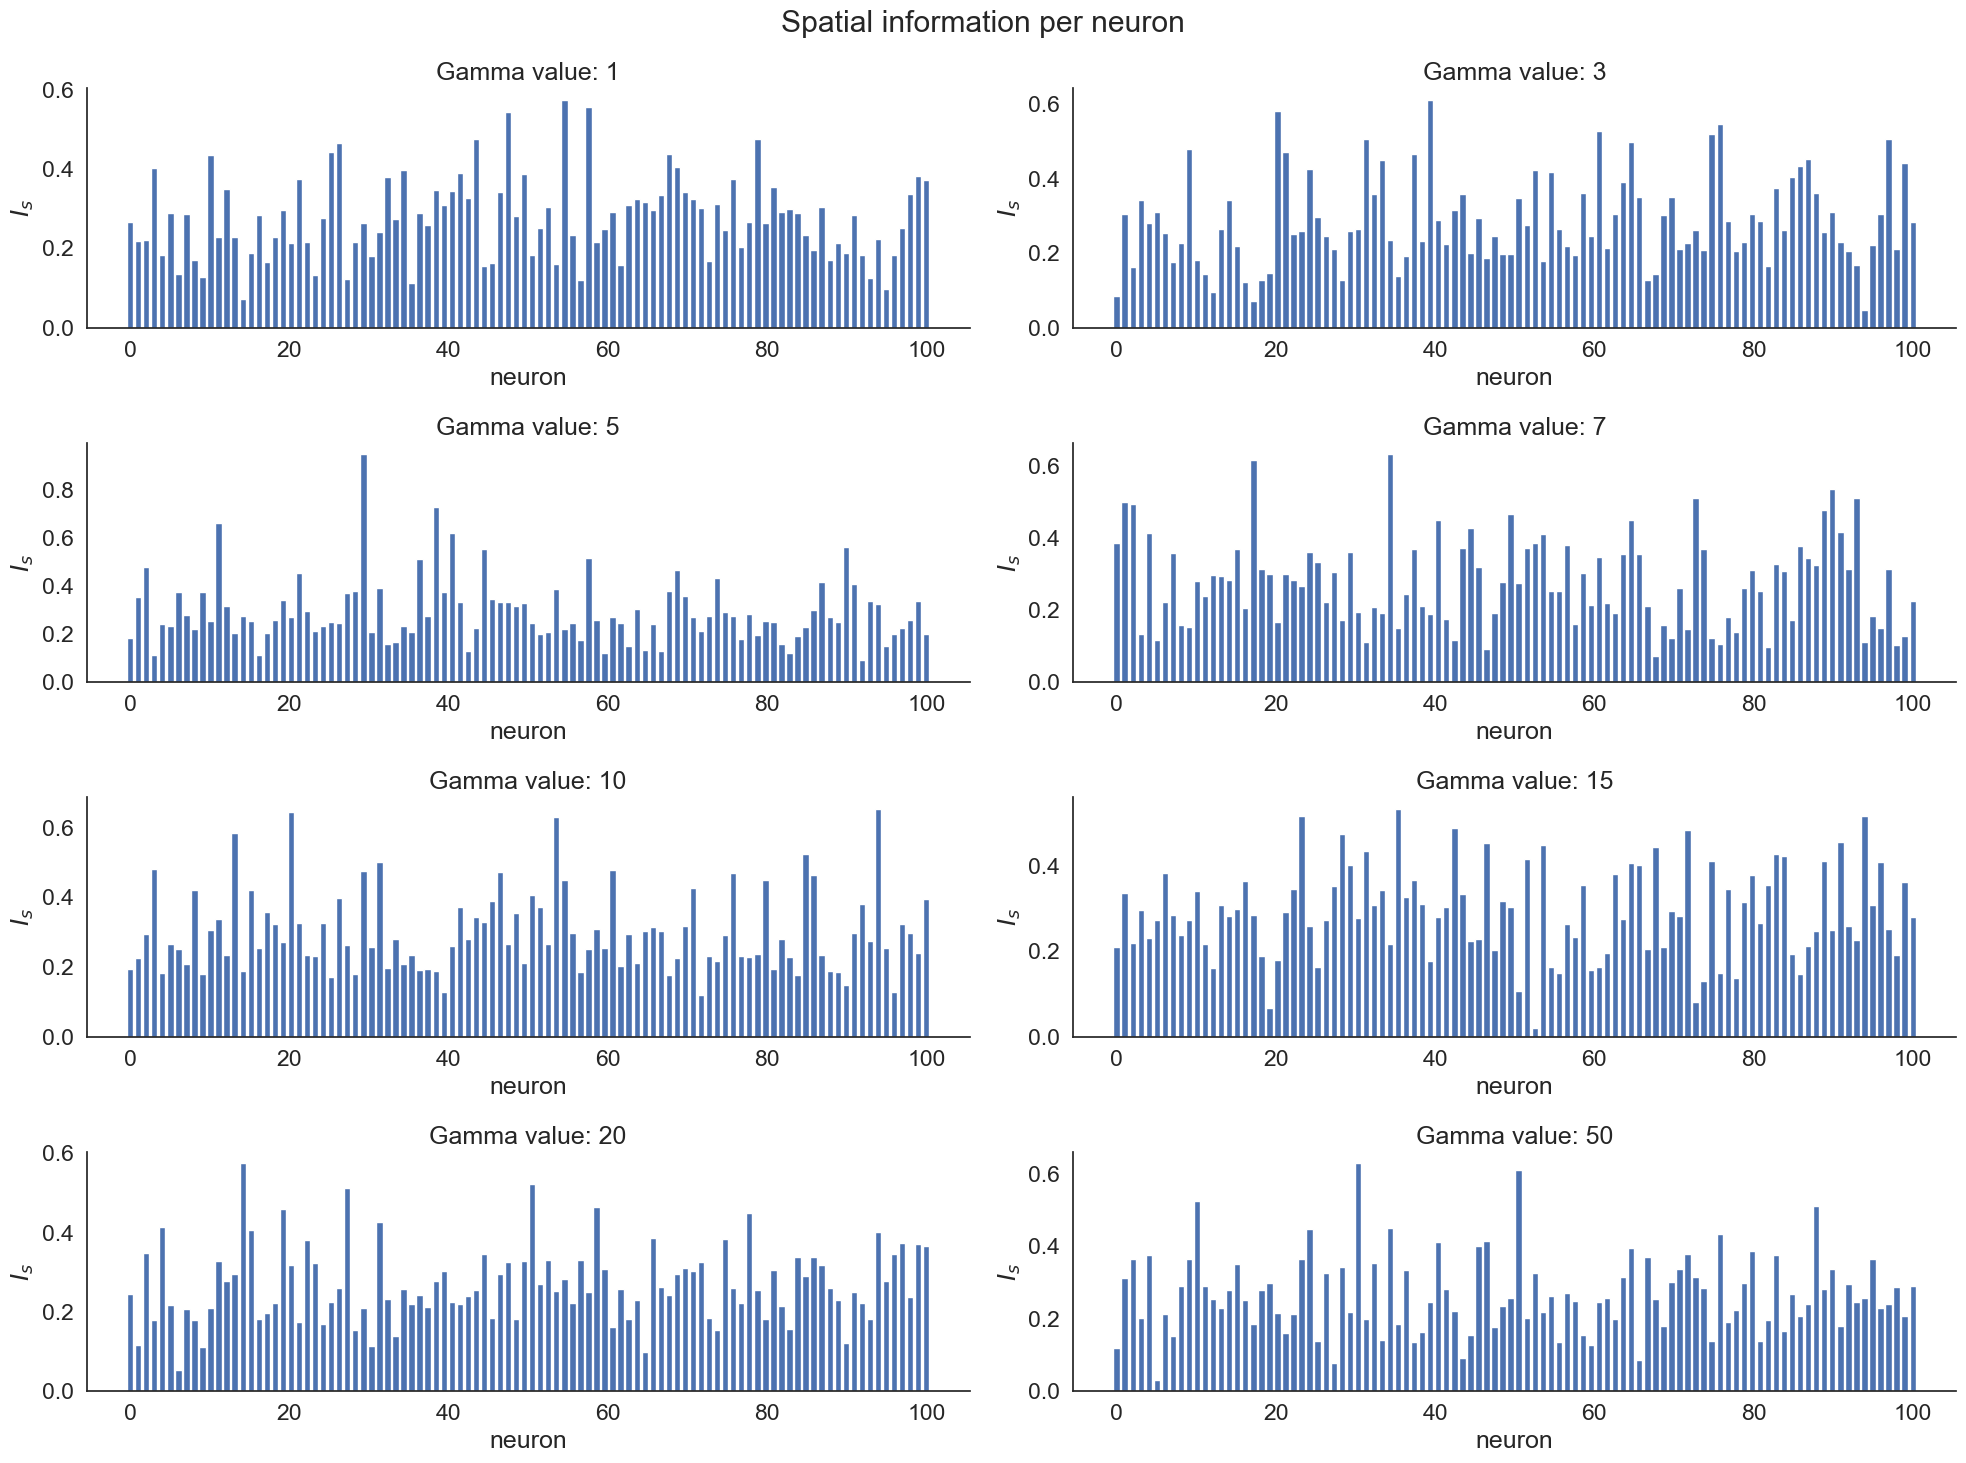

In [29]:
plt.figure(figsize=(20, 15))
plt.suptitle('Spatial information per neuron')
for k in range(len(gamma_values)):
    plt.subplot(4,2,k+1)
    plt.bar(np.linspace(0,100,100), I_s[:,k])
    plt.xlabel('neuron')
    plt.ylabel(r'$I_s$')
    plt.title('Gamma value: {}'.format(gamma_values[k]))

plt.tight_layout()
plt.show()

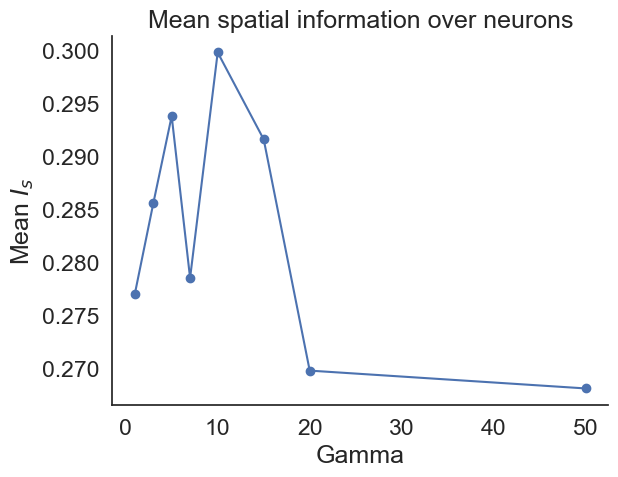

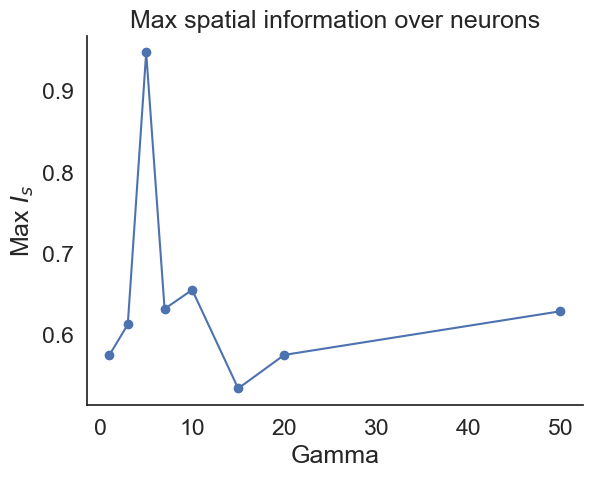

In [30]:
Is_mean = np.zeros(len(gamma_values))
Is_max = np.zeros(len(gamma_values))
for k in range(len(gamma_values)):
    Is_mean[k] = np.mean(I_s[:,k])
    Is_max[k] = np.max(I_s[:,k])

plt.plot(gamma_values, Is_mean, marker='o')
plt.xlabel('Gamma')
plt.ylabel(r'Mean $I_s$')
plt.title('Mean spatial information over neurons')
plt.show()

plt.plot(gamma_values, Is_max, marker='o')
plt.xlabel('Gamma')
plt.ylabel(r'Max $I_s$')
plt.title('Max spatial information over neurons')
plt.show()

#### Finally, lets vary the baseline noise

In [31]:
base_noises = [0.001, 0.01, 0.1, 1, 5, 10]
track_length = 200. # the length of our linear track (eg in centimeter)
average_firing_rate = 5 # the peak firing rate, averaged across the population 
n_cells = 100 # how many cells we are recording
bins = np.arange(0., 200.)
n_runs = 20 
av_running_speed = 10 # the average running speed (in cm/s)
fps = 30 # the number of "video frames" per second 
sampling_rate = 10000.
#noise_firing_rate = 0.1 # the baseline noise firing rate
space_bins = np.arange(0., 200., 5.)
epsilon = 10**(-15)
I = np.zeros([100, len(average_firing_rates)])
I_s = np.zeros([100, len(average_firing_rates)])

running_speed_a = np.random.chisquare(10, size=n_runs) # running speed in the two directions
running_speed_b = np.random.chisquare(10, size=n_runs) 
stopping_time_a = np.random.chisquare(15, size=n_runs) # the time the mouse will spend at the two ends of the track
stopping_time_b = np.random.chisquare(15, size=n_runs)
x = np.array([])
for i in range(n_runs):
    stop1 = np.ones((int(stopping_time_a[i]*fps),)) * 0.
    run_length = len(bins) * fps / running_speed_a[i]
    run1 = np.linspace(0., float(len(bins)-1), int(run_length))
    stop2 = np.ones((int(stopping_time_b[i]*fps),)) * (len(bins)-1.)
    run_length = len(bins) * fps / running_speed_b[i]
    run2 = np.linspace(len(bins)-1., 0., int(run_length))
    x = np.concatenate((x, stop1, run1, stop2, run2))
t = np.arange(len(x))/fps

In [32]:
# calculate mutual information
pf_centers = np.random.rand(n_cells) * track_length # the centers of the place fields for all cells drawn randomly with a uniform distribution on the track
pf_rate = np.random.exponential(scale=average_firing_rate, size=n_cells) # the peak firing rate for each cell, drawn from an exponential distribution
pf_size = np.random.gamma(10, size=n_cells) # the size (width) of the place fields, drawn randomly from a gamma distribution 

for k in range(len(base_noises)):
    noise_firing_rate = base_noises[k]
    true_firing_rate_maps = np.zeros((n_cells, len(bins)))
    t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
    x_sampling = np.floor(np.interp(t_sampling, t, x))
    spikes = []
    for i in tqdm(range(n_cells)):
        inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
        spikes_loc = np.random.poisson(inst_rate/sampling_rate)
        sp = np.argwhere(spikes_loc)
        t_sp = t_sampling[sp]
        spikes.append(t_sp)
    spike_positions = [np.interp(s, t, x) for s in spikes]
    spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]
    spikes_hist = np.vstack(spikes_hist).astype(np.float64)
    occupancy = np.histogram(x, space_bins)[0] /  fps
    firing_rate_maps = spikes_hist / occupancy 
    lamb = np.mean(firing_rate_maps, axis=1) # average firing rate
    lamb_x = firing_rate_maps #firing rate
    p_occ = occupancy/np.sum(occupancy)#occupancy probability
    for i in range(len(lamb_x[1])):
        I[:,k] += lamb_x[:,i]*p_occ[i]*np.log2((lamb_x[:,i]+epsilon)/(lamb[:]))
    I_s[:,k] = I[:,k]/lamb

100%|█████████████████████████████████████████| 100/100 [00:59<00:00,  1.69it/s]
/var/folders/9x/_cy0g2js5gd9sl9zbqxlqlsw0000gn/T/ipykernel_6455/4277448030.py:27: RuntimeWarning: divide by zero encountered in divide
  I[:,k] += lamb_x[:,i]*p_occ[i]*np.log2((lamb_x[:,i]+epsilon)/(lamb[:]))
/var/folders/9x/_cy0g2js5gd9sl9zbqxlqlsw0000gn/T/ipykernel_6455/4277448030.py:27: RuntimeWarning: invalid value encountered in multiply
  I[:,k] += lamb_x[:,i]*p_occ[i]*np.log2((lamb_x[:,i]+epsilon)/(lamb[:]))
100%|█████████████████████████████████████████| 100/100 [01:00<00:00,  1.66it/s]


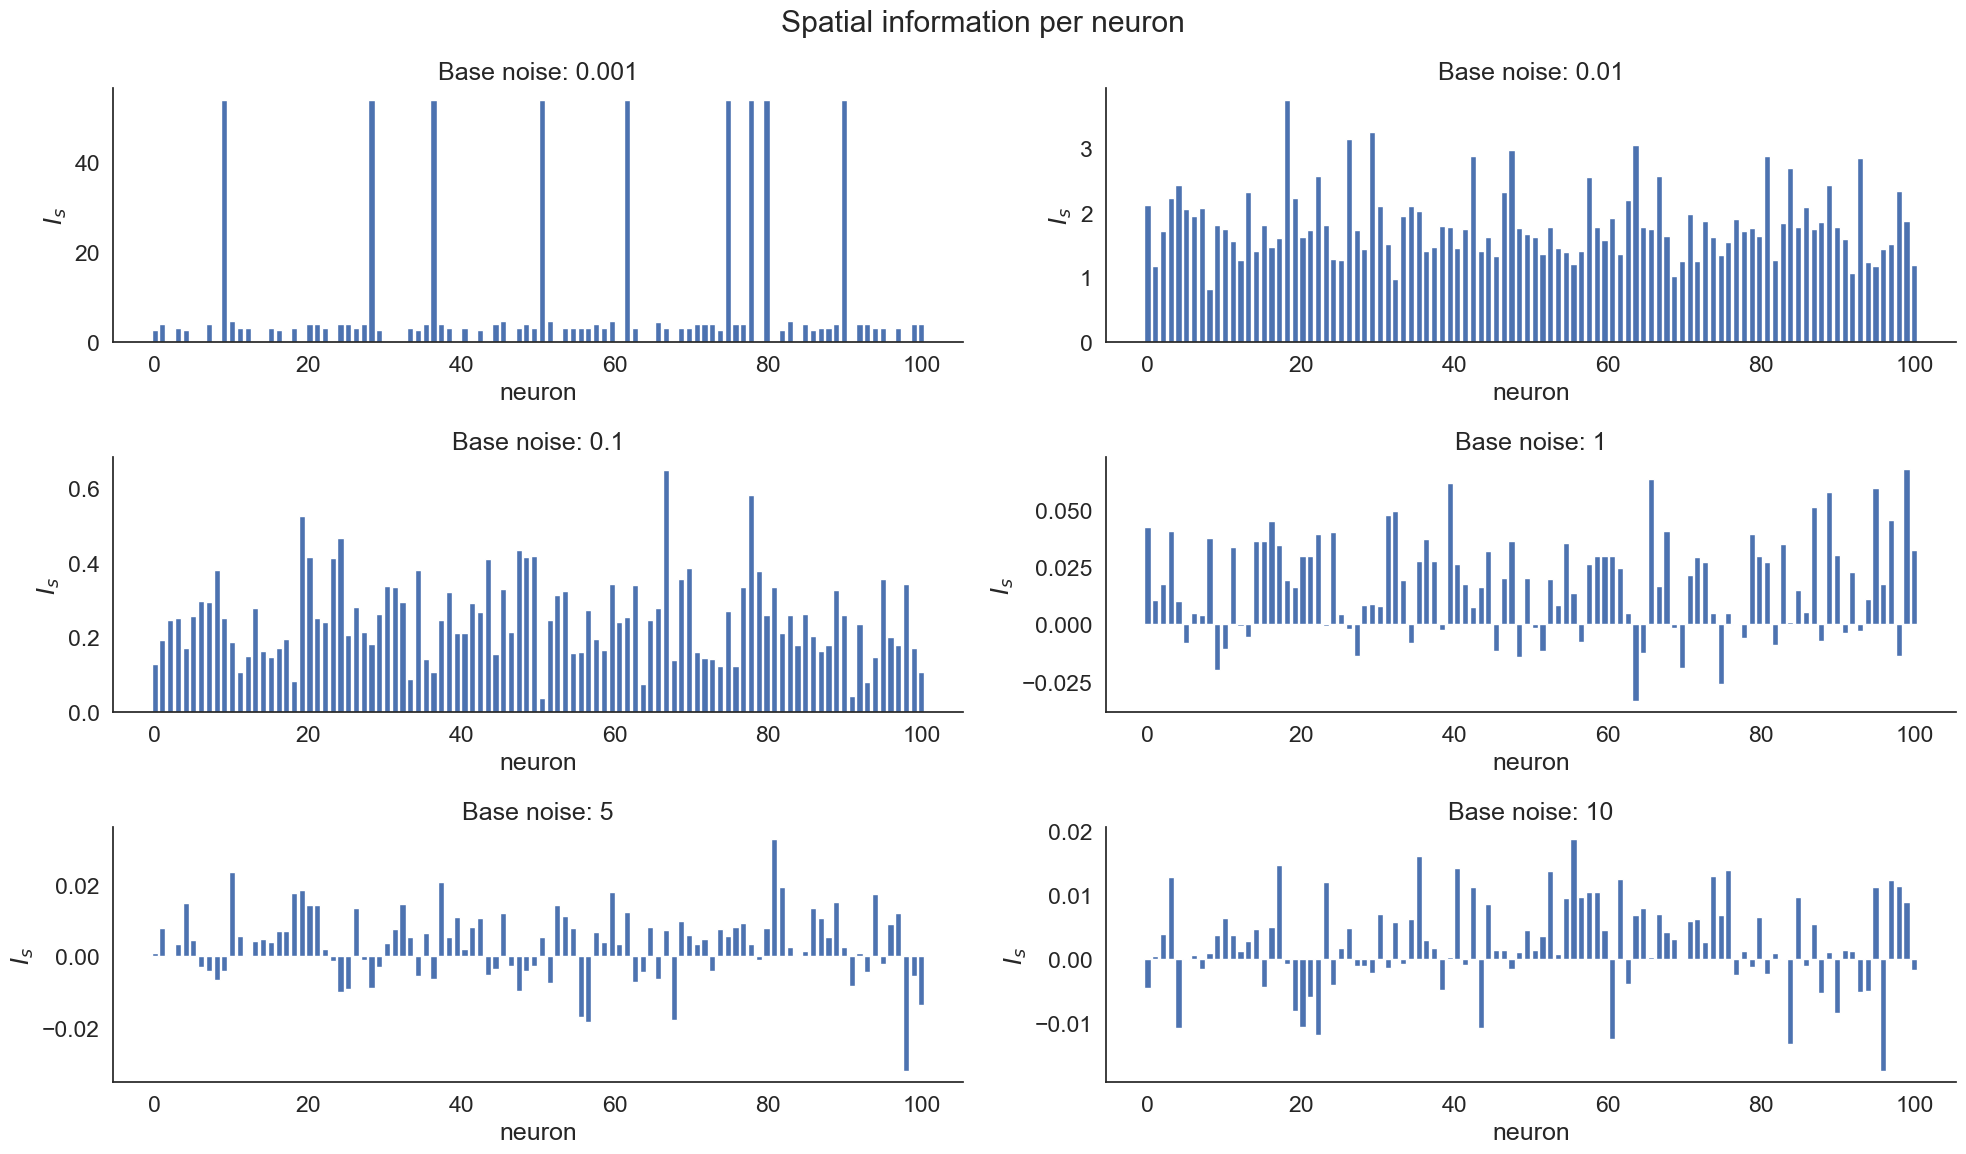

In [33]:
plt.figure(figsize=(20, 15))
plt.suptitle('Spatial information per neuron')
for k in range(len(base_noises)):
    plt.subplot(4,2,k+1)
    plt.bar(np.linspace(0,100,100), I_s[:,k])
    plt.xlabel('neuron')
    plt.ylabel(r'$I_s$')
    plt.title('Base noise: {}'.format(base_noises[k]))

plt.tight_layout()
plt.show()

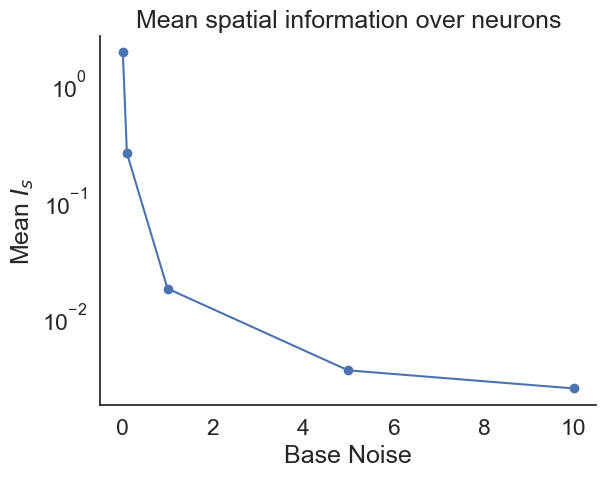

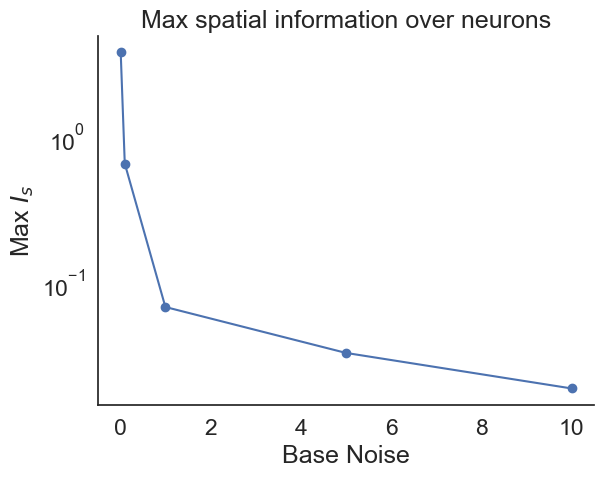

In [34]:
Is_mean = np.zeros(len(base_noises))
Is_max = np.zeros(len(base_noises))
for k in range(len(base_noises)):
    Is_mean[k] = np.mean(I_s[:,k])
    Is_max[k] = np.max(I_s[:,k])

plt.plot(base_noises, Is_mean, marker='o')
plt.xlabel('Base Noise')
plt.ylabel(r'Mean $I_s$')
plt.yscale('log')
plt.title('Mean spatial information over neurons')
plt.show()

plt.plot(base_noises, Is_max, marker='o')
plt.xlabel('Base Noise')
plt.ylabel(r'Max $I_s$')
plt.yscale('log')
plt.title('Max spatial information over neurons')
plt.show()